# Introduction

This pair of functions is short and sweet and seem to make their way into just
about every project where I have time series data in a notebook. Having spent
a lot of time looking at Tensorboard scalar plots, I'd come to really
appreciate their general style. A noisy faint curve is painted with a bold
bright (color-coordinated) smoothed variant. Tensorboard uses an exponentially
weighted moving average for the smoothing function.

When we first glance at noisy data it's common that a trend is hidden by noise,
and any moving average gives inertia to each point. I find moving averages
especially helpful when looking at data with asymptotic behavior, as the
delta between a signal and its limit will eventually be buried in the noise
term.

# So what do I want?

1. A small set of routines that I can toss into most projects
2. Few dependencies
3. Bullet proof without a significant maintenance burden. We'd like to drop it
 in somewhere, plot some graphs, and forget it exists. We don't want to find a
 bug down the line.

# Okay, let's do this.

An important rule of thumb in software development is:

> First make it work, _then_ make it fast.

In general, if there is a solution that's simple and works, then it
**shouldn't** be optimized until there is evidence that it's a bottleneck. That
being said, the following routine to calculate an exponentially-weighted moving
average still breaks my heart a little every time.

In [1]:
from typing import TypeVar
import numpy as np
from numpy import typing as npt
import pandas as pd


B = TypeVar("B", bound=npt.NBitBase)


def numpy_ewma_vectorized(
        data: npt.NDArray[np.number[B]],
        alpha: float = 0.6) -> npt.NDArray[np.floating[B]]:
    df = pd.DataFrame(data.copy(), columns=['A'])
    return df.ewm(alpha=alpha).mean()['A'].to_numpy()

That's right. Searching for an exponentially weighted moving average in the
common `numpy` or `scipy` libraries leads directly to
[this stackoverflow post](https://stackoverflow.com/q/42869495/2528639) where
dozens of implementations and ad-hoc benchmarks compete for your attention.

Some of them even work, but I've been burned a few times now. Which version of
the routine should be called? Does the documentation actually match the
implementation? Are there assumptions about the dimension of the input data?
Are there inputs where it's especially inaccurate? Crucially: **are there bugs,
and who's going to have to find and fix them?**. Pandas has yet to burn me, and
always seems to match my use case: I have a one dimensional array of evenly
sampled time series data and I need it to be smoothed out. Best of all, pandas
has yet to break my installation due to an update (looking at you `numpy`).

# I was told there would be images.

So now that we have a method to smooth out a 1D vector, we just want to wrap it
in an opinionated function that generates approximately the Tensorboard scalar
plot. Some custimization is okay, but not essential. What I've settled on is
the following. It follows a few conventions that people will recognize from
`seaborn` and other similar libraries:

1. Let the user provide an `Axes`. If they didn't it's because they don't care and just want it to show up on a new plot.
2. Let the user provide `**kwargs` to nested routines. It's a tiny escape hatch that can occasionally help. Most often, I only use it to set a color.

In [2]:
from typing import Any, Optional
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.lines import Line2D


XDT = TypeVar("XDT", bound=np.number)
YDT = TypeVar("YDT", bound=np.number)

def plot_smoothed(
        *,
        ax: Optional[Axes] = None,
        x: Optional[npt.NDArray[XDT]] = None,
        y: npt.NDArray[YDT],
        label: Optional[str] = None,
        ewma_alpha: float = 0.1,
        subplot_kwds: dict[str, Any] = {},
        plot_kwds: dict[str, Any] = {}) -> tuple[Axes, Line2D, Line2D]:
    """Plot a line as well as its expoentially wieghted moving average

    Args:
        ax (Axes, optional): The axes upon which to plot, otherwise a new
            figure will be created passing `subplot_kwds` to `plt.subplots`
        
        x (npt.NDArray[XDT], optional): sample x values. If not supplied an
            integer sequence will be used.
        
        y (npt.NDArray[YDT]): sample y values
        
        label (str, optional): The label to be applied to the smoothed line

        ewma_alpha (float, optional): the smoothing factor to be applied.

        subplot_kwds (dict[str, Any], optional): Keyword arguments supplied to
            maptlotlib when generating an axis if `ax` is not specified.

        plot_kwds (dict[str, Any], optional): Keyword arguments supplementing
            those used in this routine. For expected behavior you want to
            avoid: label, alpha, linewidth, zorder.

    Returns:
        tuple[Axes, Line2D, Line2D]: a tuple consisting of (1) the axis,
        (2) the smoothed line, and (3) the noisy line.
    """
    if "label" in plot_kwds:
        raise ValueError(
            "You probably didn't mean to put 'label' in 'plot_kwds'")

    ln_args = {"alpha": 0.3}
    ln_args.update(plot_kwds)

    ax = ax if ax is not None else plt.subplots(**subplot_kwds)[-1]
    x = x if x is not None else np.arange(len(y))
    line, = ax.plot(x, y, **ln_args)

    sm_args = {
        "alpha": 1,
        "linewidth": line.get_linewidth() * 2,
        "color": line.get_color(),
        "zorder": line.get_zorder() + 1
    }
    sm_args.update(plot_kwds)

    y_ewma = numpy_ewma_vectorized(y, ewma_alpha)
    smoothed_line, = ax.plot(x, y_ewma, label=label, **sm_args)
    return (ax, smoothed_line, line)

So what we have is 70% documentation, 20% allowing users to override parameters, and then a small 10% that's actually doing the heavy lifting here. If you want to only support accepting a 1D numpy array and want automatic-everything, this can be shrunk down to almost nothing. Let's see how it does.

In [3]:
rng = np.random.default_rng(9587437869478)
x = np.linspace(0.0, 5.0, 100)

y1 = np.cos(2*np.pi*x) * np.exp(-x) + rng.normal(0, 0.1, size=x.shape)
y2 = np.cos(1.9*np.pi*x) * np.exp(-x/2) + rng.normal(0, 0.1, size=x.shape)

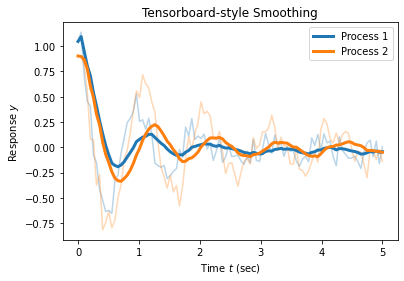

In [4]:
ax = plot_smoothed(x=x, y=y1, label="Process 1")[0]
plot_smoothed(ax=ax, x=x, y=y2, label="Process 2")
ax.legend()
ax.set_title("Tensorboard-style Smoothing")
ax.set_xlabel("Time $t$ (sec)")
_ = ax.set_ylabel("Response $y$")

# Conclusion

We get a lot of what you'd expect here. Matplotlib's default color cycle is
honored with repeat invocations on the same axis. Our plot isn't cluttered
with labels. We're able to customize the resulting figure and add additional
elements to it if we wish. We do one thing and do it well without having to
re-learn an API or reverse-engineer terse internals. Sooner or later a
respectible library will obviate the need for this littel utility, but until
then it won't be collecting much dust.

If you enjoly unecessarily deep dives like these or if  you'd like to see other
content, [checkout my blog](https://rob-hall.com/articles).